In [ ]:
#! pip install kaggle
#! mkdir ~/.kaggle
#! cp /content/kaggle.json ~/.kaggle/


In [ ]:
#!kaggle datasets download -d vvmansi/256-192-dataset

In [ ]:
#!unzip /content/256-192-dataset.zip

In [1]:
import os
from glob import glob
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
X_train = np.load("../input/256-192-dataset/256_192_train.npy")
y_train = np.load("../input/256-192-dataset/train_labels.npy")
X_val = np.load("../input/256-192-dataset/256_192_val.npy")
y_val = np.load("../input/256-192-dataset/val_labels.npy")

In [3]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [5]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10)

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)


Training Without Fine-Tuning

In [6]:
pre_trained_model = InceptionV3(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

2022-04-02 14:21:45.420301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 14:21:45.515852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 14:21:45.516568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 14:21:45.517793: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 0s 0us/step


In [7]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

In [8]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 6, 2048)


In [10]:
from keras import layers
from tensorflow.keras.optimizers import Adam

# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 95, 127, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 95, 127, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
for layer in pre_trained_model.layers:
    layer.trainable = True

In [13]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 95, 127, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 95, 127, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
batch_size = 64
epochs = 40

In [17]:
history=model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction]
                           )

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-04-02 14:24:43.870742: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-04-02 14:24:51.716018: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


126/126 [==============================] - 109s 753ms/step - loss: 1.1379 - acc: 0.6610 - val_loss: 1.4845 - val_acc: 0.6808
Epoch 2/40
126/126 [==============================] - 91s 722ms/step - loss: 0.7438 - acc: 0.7383 - val_loss: 0.7982 - val_acc: 0.7567
Epoch 3/40
126/126 [==============================] - 93s 735ms/step - loss: 0.6253 - acc: 0.7767 - val_loss: 0.6806 - val_acc: 0.7545
Epoch 4/40
126/126 [==============================] - 91s 723ms/step - loss: 0.5445 - acc: 0.8095 - val_loss: 0.5292 - val_acc: 0.8036
Epoch 5/40
126/126 [==============================] - 92s 731ms/step - loss: 0.4785 - acc: 0.8309 - val_loss: 0.5528 - val_acc: 0.7879
Epoch 6/40
126/126 [==============================] - 92s 730ms/step - loss: 0.4217 - acc: 0.8467 - val_loss: 0.5769 - val_acc: 0.8125
Epoch 7/40
126/126 [==============================] - 92s 731ms/step - loss: 0.3863 - acc: 0.8576 - val_loss: 0.5946 - val_acc: 0.7969
Epoch 8/40
126/126 [==============================] - 92s 732ms/s

In [20]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

2022-04-02 15:43:18.243603: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 532021248 exceeds 10% of free system memory.
2022-04-02 15:43:18.780477: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 532021248 exceeds 10% of free system memory.


29/29 [==============================] - 3s 57ms/step - loss: 0.7240 - acc: 0.8570
Validation: accuracy = 0.856984  ;  loss_v = 0.723977


In [21]:
X_test = np.load("../input/256-192-dataset/256_192_test.npy")
y_test = np.load("../input/256-192-dataset/test_labels.npy")

y_test = to_categorical(y_test)


test_generator = test_datagen.flow(X_test, y_test)

In [22]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_test, loss_test))

2022-04-02 15:44:19.898199: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 591003648 exceeds 10% of free system memory.
2022-04-02 15:44:20.544255: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 591003648 exceeds 10% of free system memory.


32/32 [==============================] - 2s 57ms/step - loss: 0.7229 - acc: 0.8663
Validation: accuracy = 0.866267  ;  loss_v = 0.722912


In [23]:
model.save("./InceptionV3.h5")

In [24]:
y_pred=model.predict_generator(X_test)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
K.int_shape(y_pred)

(1002, 7)

In [26]:
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 14   3   8   1   1   0   1]
 [  1  44   9   0   2   0   1]
 [  2   1  84   0  11   0  10]
 [  0   0   1  10   3   0   1]
 [  0   3  17   1 645   0  12]
 [  0   0   0   1   1  12   0]
 [  0   2  11   1  29   0  59]]


In [27]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.82      0.50      0.62        28
     class 1       0.83      0.77      0.80        57
     class 2       0.65      0.78      0.71       108
     class 3       0.71      0.67      0.69        15
     class 4       0.93      0.95      0.94       678
     class 5       1.00      0.86      0.92        14
     class 6       0.70      0.58      0.63       102

    accuracy                           0.87      1002
   macro avg       0.81      0.73      0.76      1002
weighted avg       0.87      0.87      0.86      1002



dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


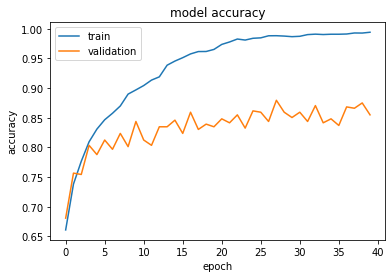

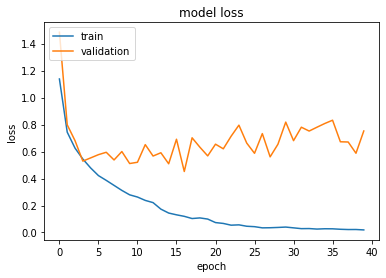

In [29]:
# summarize history for accuracy
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
#plt.plot(history.history['test_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(history.history['test_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation','test'], loc='upper left')
plt.show()


In [30]:
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
result = sensitivity_specificity_support(y_test,y_pred,average='macro' )

print("Sensitivity: {:5.2f}%".format(100*result[0]), "specificity {:5.2f}%".format(100*result[1]))

Sensitivity: 72.90% specificity 96.56%


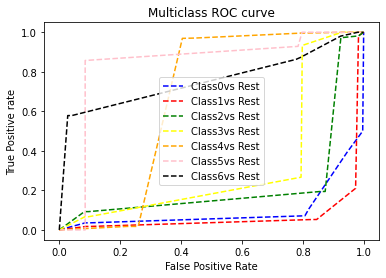

In [31]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred, pos_label=i)
    
# plotting

colors=['blue','red','green','yellow','orange','pink','black']

for i in range(0,7):
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i], label='Class'+ str(i) +'vs Rest')


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);